In [1]:
import xarray as xr
import datetime
import numpy as np
import s3fs
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
def open_zarrs(year, month, datestart, dateend):
    fs = s3fs.S3FileSystem(anon=True)
    
    datestring = 'era5-pds/zarr/{year}/{month:02d}/data/'.format(year=year, month=month)
    
    mslp_zarr = xr.open_zarr(s3fs.S3Map(datestring + 'air_pressure_at_mean_sea_level.zarr/', s3=fs))
    mslp_zarr = mslp_zarr.sel(time0=slice(np.datetime64(datestart), np.datetime64(dateend)))
    
    airt_zarr = xr.open_zarr(s3fs.S3Map(datestring + 'air_temperature_at_2_metres.zarr/', s3=fs))
    airt_zarr = airt_zarr.sel(time0=slice(np.datetime64(datestart), np.datetime64(dateend)))
    
    precip_zarr = xr.open_zarr(s3fs.S3Map(datestring + 'precipitation_amount_1hour_Accumulation.zarr/', s3=fs))
    precip_zarr = precip_zarr.sel(time1=slice(np.datetime64(datestart), np.datetime64(dateend)))
    
    return (mslp_zarr, airt_zarr, precip_zarr)

In [3]:
mslp, airt, precip = open_zarrs(1987, 12, '1987-12-02', '1987-12-02 23:59')

In [4]:
precip_data = precip.precipitation_amount_1hour_Accumulation[12,:,:].values

In [5]:
mslp_data = mslp.air_pressure_at_mean_sea_level[12,:,:].values
mslp_data = mslp_data * 0.01 # Pa to hPa

In [6]:
airt_data = airt.air_temperature_at_2_metres[12,:,:].values
airt_data =  (airt_data - 273.15) * 9/5 + 32.0 # K to F

In [7]:
lat = mslp.lat.values
lon = mslp.lon.values

In [8]:
lons, lats = np.meshgrid(lon, lat)

Text(0.5, 0.98, 'December 2nd Weather')

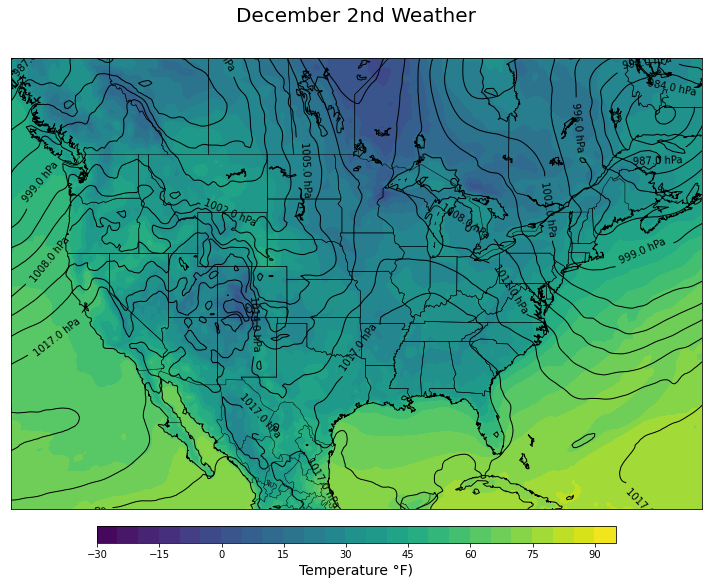

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(llcrnrlon = 230., llcrnrlat = 20., urcrnrlon = 300., urcrnrlat = 55., resolution = 'l', projection = 'merc', ax = ax)

x, y = m(lons, lats)

# Plot Temperature data
clevs = np.arange(-30, 100, 5.)
t_c = m.contourf(x, y, airt_data, clevs)

# Plot MSLP contours every 3 hPa
clevs = np.arange(900, 1100., 3.)
mslp_c = m.contour(x, y, mslp_data, clevs, colors='k', linewidths=1.)
fmt = '%r hPa'
plt.clabel(mslp_c, mslp_c.levels, inline=True, fmt=fmt, fontsize=10)


m.drawcoastlines()
m.drawstates()
m.drawcountries()

cbax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar=plt.colorbar(mappable=t_c, cax=cbax, orientation='horizontal')
cbar.set_label('Temperature °F)', fontsize=14)
plt.suptitle('December 2nd Weather', fontsize=20)